In [5]:
#Import Libraries
import subprocess
import re
import pandas as pd
import os
import collections
import scipy.stats
import numpy as np
import scipy
import csv
import math
import seaborn as sns

from functools import reduce
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
from pandas.tools.plotting import table
from scipy import interp
from sklearn import svm
from sklearn.svm import SVC
from sklearn.datasets import make_blobs, make_classification


from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV, LeaveOneOut, train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, auc, roc_curve, precision_recall_curve, f1_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#Data Load
dset_a=pd.read_csv("new_data/gene_exprs/res_sl_bh_ge.csv", delimiter=',')
dset_b=pd.read_csv("new_data/gene_exprs/res_ss_bh_ge.csv", delimiter=',')
dset_c=pd.read_csv("new_data/gene_exprs/sl_ss_bh_ge.csv", delimiter=',')

In [4]:
d=dset_a.append(dset_b, ignore_index=True, sort=True)
dset=d.append(dset_c, ignore_index=True, sort=True)

In [8]:
dset_a=pd.read_csv("new_data/gene_exprs/res_sl_bh_ge.csv", delimiter=',')
dset_a.head()

,gene,resistant_median,sensitive_long_median,mannwhiteney_pvalue,p_value_corr_bh,ensemble_id,gene_symbol
0,ENSG00000106144.18-CASP2,7.470207,10.073108,0.000509,0.001774,ENSG00000106144.18,CASP2
1,ENSG00000071967.10-CYBRD1,27.088610,14.599910,0.000585,0.001775,ENSG00000071967.10,CYBRD1
2,ENSG00000139629.14-GALNT6,5.780338,9.432510,0.000569,0.001784,ENSG00000139629.14,GALNT6
3,ENSG00000177383.4-MAGEF1,40.393938,66.782924,0.000228,0.001784,ENSG00000177383.4,MAGEF1
4,ENSG00000008952.15-SEC62,20.588895,25.519509,0.000554,0.001795,ENSG00000008952.15,SEC62


In [68]:
x = dset[dset.columns[0:1]] 
x.head()

,ensemble_id
0,ENSG00000106144.18
1,ENSG00000071967.10
2,ENSG00000139629.14
3,ENSG00000177383.4
4,ENSG00000008952.15


In [69]:
lista1=set(x['ensemble_id'])

In [70]:
dset_res=pd.read_csv("clintab_GMQL/gene_exprs/res/res_new.csv", delimiter='\t')
dset_senl=pd.read_csv("clintab_GMQL/gene_exprs/sl_32/sl_new.csv", delimiter='\t')
dset_sens=pd.read_csv("clintab_GMQL/gene_exprs/ss_32/ss_new.csv", delimiter='\t')

In [71]:
dset_r = dset_res[dset_res.ensemble_id.isin(lista1)]
protein_coding_res=pd.DataFrame(dset_r)
#protein_coding_res['genes'] = protein_coding_res['ensemble_id']+'-'+ protein_coding_res['gene_symbol']
protein_coding_res.head()

,patient,chrom,start,stop,ensemble_id,entrez_id,gene_symbol,fpkm_uq,fpkm
29,R_00000,chr1,450739,451678,ENSG00000278566.1,729759.0,OR4F29,0.000000e+00,0.000000
230,R_00000,chr1,6181268,6209389,ENSG00000116251.8,6146.0,RPL22,2.773390e+06,107.534581
329,R_00000,chr1,9827609,9828258,ENSG00000280113.1,NaN,AL357140.1,2.001081e+03,0.077589
503,R_00000,chr1,15572352,15585110,ENSG00000116771.5,79814.0,AGMAT,2.753247e+04,1.067536
756,R_00000,chr1,23691778,23696425,ENSG00000142676.11,6135.0,RPL11,2.232890e+07,865.774178


In [72]:
dset_sl = dset_senl[dset_senl.ensemble_id.isin(lista1)]
protein_coding_senl=pd.DataFrame(dset_sl)
#protein_coding_senl['genes'] = protein_coding_senl['ensemble_id']+'-'+ protein_coding_senl['gene_symbol']

In [73]:
dset_ss = dset_sens[dset_sens.ensemble_id.isin(lista1)]
protein_coding_sens=pd.DataFrame(dset_sens)
#protein_coding_sens['genes'] = protein_coding_sens['ensemble_id']+'-'+ protein_coding_sens['gene_symbol']

In [74]:
resdf=protein_coding_res.pivot(index="patient", columns="ensemble_id", values="fpkm")
genes = resdf.columns.tolist()

In [75]:
senldf=protein_coding_senl.pivot(index="patient", columns="ensemble_id", values="fpkm")
senldf = senldf[genes]

In [76]:
sensdf=protein_coding_sens.pivot(index="patient", columns="ensemble_id", values="fpkm")
sensdf = sensdf[genes]

In [77]:
resdf['label']=np.ones(len(resdf.index))
sensdf['label']=np.zeros(len(sensdf.index))
senldf['label']=np.zeros(len(senldf.index))
sen=pd.concat([sensdf, senldf])
#senldf['label']=np.full(len(senldf.index), 2)
#tot=pd.concat([sensdf, resdf, senldf])
tot=pd.concat([sen, resdf])

In [78]:
X=tot[tot.columns[:-1]].values
y=tot[tot.columns[-1]].values

In [79]:
kf = StratifiedKFold(n_splits=10)
recall=[]
precision=[]
accuracy=[]
fscore=[]
scores=['true_sen', 'false_res', 'true_res', 'false_sen', 'accuracy', 'precision', 'recall', 'f1_score']
performance=pd.DataFrame(index=np.arange(10), columns=scores)
i=0
for train_index, test_index in kf.split(X, y):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    '''X=pd.DataFrame(x_train, columns=features)
    model= RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced')
    model.fit(X,y_train)
    f=feat_importances.nlargest(15).index
    x_train=X[f].values
    X_t=pd.DataFrame(x_test, columns=features)
    x_test=X_t[f]'''
    
    print('real')
    print(y_test)
    
    #clf = RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced')
    clf=KNeighborsClassifier(n_neighbors=3, metric='manhattan')
    #clf = AdaBoostClassifier(n_estimators=200, base_estimator=DecisionTreeClassifier(max_depth=5),random_state=0)
    #clf=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
    #clf = svm.SVC(kernel='rbf', C=100, probability=True, gamma = 0.0001, class_weight='balanced', random_state=42)
    
    clf.fit(x_train, y_train)
    y_pred=clf.predict(x_test)
    print('predicted')
    print(y_pred)
    recall.append(recall_score(y_test, y_pred, average=None))
    precision.append(precision_score(y_test, y_pred, average=None))
    accuracy.append(accuracy_score(y_test, y_pred))
    fscore.append(f1_score(y_test, y_pred, average=None))
    performance.iloc[i]['accuracy']=accuracy_score(y_test, y_pred)
    performance.iloc[i]['precision']=precision_score(y_test, y_pred, average=None)
    performance.iloc[i]['recall']=recall_score(y_test, y_pred, average=None)
    performance.iloc[i]['f1_score']=f1_score(y_test, y_pred, average=None)
    c_matrix=confusion_matrix(y_test, y_pred)
    performance.iloc[i]['true_sens']=c_matrix[0][0]
    performance.iloc[i]['false_sens']=c_matrix[1][0]
    #performance.iloc[i]['false_sens']=c_matrix[2][0]
    performance.iloc[i]['true_res']=c_matrix[1][1]
    performance.iloc[i]['false_res']=c_matrix[0][1]
    #performance.iloc[i]['false_res']=c_matrix[2][1]
    #performance.iloc[i]['true_senl']=c_matrix[2][2]
    #performance.iloc[i]['false_senl']=c_matrix[0][2]
    #performance.iloc[i]['false_senl']=c_matrix[1][2]
    print (i)
    i=i+1

real
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
predicted
[0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0.]
0
real
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
predicted
[0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
1
real
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
predicted
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
2
real
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
predicted
[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
3
real
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
predicted
[1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1.]
4
real
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
predicted
[0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0.]
5
real
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
predicted
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
6
real
[0

In [80]:
print('Average precision: ', np.mean(precision))
print('Average recall: ', np.mean(recall))
print('Average accuracy: ', np.mean(accuracy))
print('Average f_score: ', np.mean(fscore))

print('Standard_deviation precision: ', np.std(precision))
print('Standard_deviation recall: ', np.std(recall))
print('Standard_deviation accuracy: ', np.std(accuracy))
print('Standard_deviation f_score: ', np.std(fscore))

Average precision:  0.5624809708265591
Average recall:  0.548095238095238
Average accuracy:  0.6273809523809525
Average f_score:  0.5402894068297294
Standard_deviation precision:  0.20593194035181964
Standard_deviation recall:  0.2528383097640738
Standard_deviation accuracy:  0.0870676881106026
Standard_deviation f_score:  0.2191633543933978


## Random useful code

In [32]:
common_genes=pd.read_csv('common_genes/miRNA_common_genes.csv', sep='\t')
type(common_genes)

pandas.core.frame.DataFrame

In [22]:
column=common_genes['miRNA_id']
column.head()

0    hsa-mir-1301
1    hsa-mir-1180
2    hsa-mir-200a
3    hsa-mir-1307
4    hsa-mir-3200
Name: miRNA_id, dtype: object

In [23]:
res_selected=resdf[column]
res_selected["label"]=1
res_selected.shape

/home/lalli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(60, 23)

In [24]:
senl_selected=senldf[column]
senl_selected["label"]=2
senl_selected.shape

/home/lalli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(34, 23)

In [25]:
sens_selected=sensdf[column]
sens_selected["label"]=0
sens_selected.shape

/home/lalli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(107, 23)

In [26]:
concatenated=pd.concat([sens_selected, res_selected, senl_selected])

In [27]:
X=concatenated[concatenated.columns[:-1]].values
y=concatenated[concatenated.columns[-1]].values

In [28]:
def my_PCA(x, features, labels, i, j):
    #x = data.loc[:, features].values
    x = StandardScaler().fit_transform(x)
    
    pca= PCA(n_components=3)
    p_comp=pca.fit_transform(x)
    p_comp=p_comp[:, [i,j]]
    
    principalDf = pd.DataFrame(data = p_comp
             , columns = ['principal component '+str(i+1), 'principal component '+str(j+1)])
    finalDf= pd.concat([principalDf, pd.Series(labels)], axis=1)
    
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component '+str(i+1), fontsize = 15)
    ax.set_ylabel('Principal Component '+str(j+1), fontsize = 15)
    ax.set_title('2 Component PCA', fontsize = 20)


    targets = ['Sens_l', 'Resistant', 'Sens_s']
    #targets = ['Sens_l', 'Resistant']
    colors = ['r', 'g', 'b']
    for target, color in zip(targets,colors):
        t=0
        if target == 'Resistant':
            t=1
        if target == 'Sens_l':
            t=2
            
        indicesToKeep = finalDf[0] == t
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component '+str(i+1)]
                   , finalDf.loc[indicesToKeep, 'principal component '+str(j+1)]
                   , c = color
                   , s = 50)
    ax.legend(targets)
    ax.grid()
    

<function __main__.my_PCA(x, features, labels, i, j)>

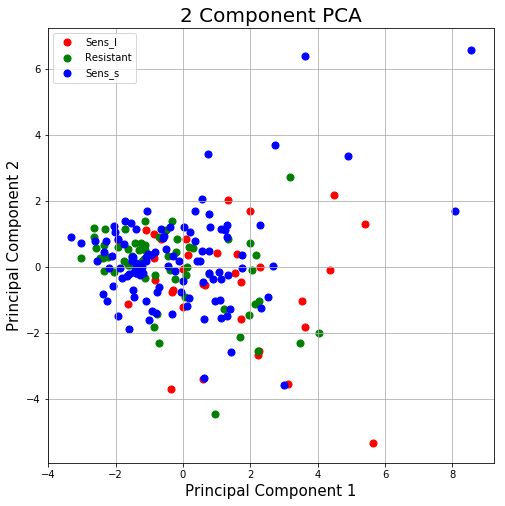

In [29]:
my_PCA(X, concatenated.columns, y, 0, 1)
my_PCA

In [30]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.5, random_state=0)
sss.get_n_splits(X, y)
#kf = StratifiedKFold(n_splits=10)
recall=[]
precision=[]
accuracy=[]
fscore=[]
scores=['true_sen', 'false_res', 'true_res', 'false_sen', 'accuracy', 'precision', 'recall', 'f1_score']
performance=pd.DataFrame(index=np.arange(10), columns=scores)
i=0
for train_index, test_index in sss.split(X, y):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    '''X=pd.DataFrame(x_train, columns=features)
    model= RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced')
    model.fit(X,y_train)
    f=feat_importances.nlargest(15).index
    x_train=X[f].values
    X_t=pd.DataFrame(x_test, columns=features)
    x_test=X_t[f]'''
    
    print('real')
    print(y_test)
    
    #clf = RandomForestClassifier(n_estimators=200, max_depth=15, class_weight='balanced')
    #clf=KNeighborsClassifier(n_neighbors=3, metric='manhattan')
    #clf = AdaBoostClassifier(n_estimators=200, base_estimator=DecisionTreeClassifier(max_depth=5),random_state=0)
    #clf=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
    clf = svm.SVC(kernel='rbf', C=100, probability=True, gamma = 0.0001, class_weight='balanced', random_state=42)
    
    clf.fit(x_train, y_train)
    y_pred=clf.predict(x_test)
    print('predicted')
    print(y_pred)
    recall.append(recall_score(y_test, y_pred, average=None))
    precision.append(precision_score(y_test, y_pred, average=None))
    accuracy.append(accuracy_score(y_test, y_pred))
    fscore.append(f1_score(y_test, y_pred, average=None))
    performance.iloc[i]['accuracy']=accuracy_score(y_test, y_pred)
    performance.iloc[i]['precision']=precision_score(y_test, y_pred, average=None)
    performance.iloc[i]['recall']=recall_score(y_test, y_pred, average=None)
    performance.iloc[i]['f1_score']=f1_score(y_test, y_pred, average=None)
    c_matrix=confusion_matrix(y_test, y_pred)
    performance.iloc[i]['true_sens']=c_matrix[0][0]
    performance.iloc[i]['false_sens']=c_matrix[1][0]
    performance.iloc[i]['false_sens']=c_matrix[2][0]
    performance.iloc[i]['true_res']=c_matrix[1][1]
    performance.iloc[i]['false_res']=c_matrix[0][1]
    performance.iloc[i]['false_res']=c_matrix[2][1]
    performance.iloc[i]['true_senl']=c_matrix[2][2]
    performance.iloc[i]['false_senl']=c_matrix[0][2]
    performance.iloc[i]['false_senl']=c_matrix[1][2]
    print (i)
    i=i+1

real
[1 2 1 0 1 0 2 0 1 2 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 2 1 0 1 1 1 0 0 0 2 0 0
 0 0 1 0 0 0 0 2 0 0 0 0 1 0 0 0 1 0 1 2 0 1 2 0 1 1 0 0 0 2 0 0 1 0 2 1 1
 2 0 1 1 0 0 1 0 0 1 2 0 0 0 1 2 0 1 1 0 2 2 2 1 0 0 2]
predicted
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0
real
[2 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 1 1 2 0 0 2 1 1 1 2 0 1 1 0 1 0
 0 0 0 2 0 0 1 0 0 1 1 0 0 0 1 0 1 0 2 2 0 0 1 0 2 1 0 2 2 0 0 1 0 1 2 0 1
 0 0 1 1 1 2 2 0 0 0 1 0 0 1 2 0 2 0 0 0 0 0 0 0 1 2 2]
predicted
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
1
real
[0 0 1 0 2 0 0 0 0 0 0 1 0 2 0 0 1 1 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0
 2 0 0 0 0 1 2 2 2 0 1 0 1 0 0 1 0 1 1 0 0 0 1 2 1 0 0 0 2 0 0

/home/lalli/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lalli/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lalli/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lalli/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lalli/anaconda3/lib/py

6
real
[0 0 1 1 2 2 1 2 0 1 1 0 0 0 2 0 1 1 0 0 0 0 0 2 0 2 0 1 1 0 0 0 1 0 0 0 0
 2 0 0 2 2 1 2 1 2 1 1 0 1 0 0 0 0 1 0 1 0 2 1 0 1 2 0 0 2 0 1 0 0 1 0 0 1
 1 0 2 1 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 2 1 1 1 0 1 0 1]
predicted
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
7
real
[1 0 2 1 1 0 0 0 1 0 0 0 0 0 0 0 0 2 1 0 0 0 1 0 0 2 2 0 2 1 0 0 0 1 0 1 0
 2 2 0 0 1 1 1 0 0 1 1 2 1 1 0 0 0 2 2 0 0 0 1 0 0 1 1 0 1 0 0 0 1 0 0 0 0
 0 2 2 2 1 1 1 2 0 0 0 0 2 1 0 0 0 1 2 1 2 0 1 1 0 0 1]
predicted
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
8
real
[0 0 1 0 0 1 2 0 1 1 1 1 0 2 0 1 0 2 1 1 1 1 2 1 0 0 2 0 0 2 1 0 1 0 0 0 0
 1 1 2 1 0 0 0 1 2 0 0 0 1 2 0 0 1 0 2 2 2 0 1 2 1 0 0 1 1 0

/home/lalli/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lalli/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lalli/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lalli/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lalli/anaconda3/lib/py

In [31]:
print('Average precision: ', np.mean(precision))
print('Average recall: ', np.mean(recall))
print('Average accuracy: ', np.mean(accuracy))
print('Standard_deviation precision: ', np.std(precision))
print('Standard_deviation recall: ', np.std(recall))
print('Standard_deviation accuracy: ', np.std(accuracy))

Average precision:  0.17821782178217827
Average recall:  0.3333333333333333
Average accuracy:  0.5346534653465348
Standard_deviation precision:  0.25203806062094763
Standard_deviation recall:  0.4714045207910317
Standard_deviation accuracy:  1.1102230246251565e-16
